# Trump's Twitter History: Data Cleaning
Those reading this will already be familiar with the political career of Donald Trump, and will no doubt understand the level of influence his twitter account, as well as his television interviews and meetings with the press had in communicating his political message. Often, his tweets were headline news in publications around the globe, and were not uncommon to captured the attention of the world. His twitter account was suspended as of January 8th, 2021, and has not been renstated as of March 19th, 2021.  
His complete twitter history has been archived thanks to https://www.thetrumparchive.com/, which I have used as my source of data for the following notebooks.
  
Why take the time to preform an overview analysis of Trump's twitter career? Well, most influencial political leaders of the past are nearly completly lost to history. How many speechs of Roman emperors do you know? How many of there speeches even remain?  
That is what makes this dataset interesting as a historical artifact. We, as data scientists/data analysts, have a chance observe and study this political artifact before it is lost to the memory of human kind. In addition, analysing this dataset allows us to imagine how political leaders of the future will use their rising technological powers to rule the populos of the future.  
  
Having said that, this series of notebooks will serve more so as an investigation of modern natural language processing and data analisys techniques. Both experimental and fundemental, to see what insights we can extract from a twitter account alone.  
  
The most interesting of questions, that off the so called 'ratio', cannot be discussed here as per number of responses were not recorded in the original data set, and may now be lost to time forever. If there are any enterprising readers out there who may know how to get there hands on such data, you may hold the answers to the most interesting questions of all. 

## Trump Twitter Series
I will do a total of three notebooks on the Trump Twitter archive.  
1) Data Cleaning, and Creation of Custom Topics.  
2) Analysis of the Data.  
3) Evaluation of off of the Shelf NLP Machine Learning Techniques.  

## Table of Content
Section 1: Data Retreval and Package Download  
Section 2.1: Extracting Quote Tweets  
Secion 2.2: Extracting Hashtags and Mentions  
Section 2.3: Extracting Datetime Information  
Section 2.4: Sentiment Analysis  
Section 2.5: Category Extraction  
Section 2.6: Category Coherence Analysis

#### Section 1: Data Retreval and Package Download

In [1]:
# Import the Relevent Packages
import pandas as pd
import os
import re
import math
import statistics as sts
import datetime as dt
import time
import seaborn as sns
from matplotlib import pyplot as plt
import spacy
spacy_model = spacy.load('en_core_web_sm')

import random as rd
from textblob import TextBlob
from wordcloud import WordCloud

In [2]:
# Change for Github Upload
# Set working dir
os.chdir('C:\\Users\\John\\Desktop\\SpeakAi')

In [3]:
# Change for Github Upload
# Downloading the data
tweets = pd.read_csv('TrumpTweetsDeleted.csv')

In [4]:
# Examine our Data.
tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


### Section 2.1 Extracting Quote Tweets.
#### Types of Tweets
The first thing to mention when examining the tweets is that there appear to be three types of tweets.  
1) Regular Trump Tweets.  
2) Tweets that have been retweeted by Trump. These tweets are disinquesed in two ways, they all begin with RT in the text, and isRetweet is valued at 't'.   
3) Quote tweets; similar to a retweet, but not flagged by isRetweet. These tweets can be detected by the """@user that begins the text string. To deal with this we will both extract the username, the quoted message, and the additional message added by trump.  

In [5]:
# 1) An example of a standard tweet.
tweets.loc[(54,'text')]

'The “Surrender Caucus” within the Republican Party will go down in infamy as weak and ineffective “guardians” of our Nation, who were willing to accept the certification of fraudulent presidential numbers!'

In [6]:
# 2) An example of a retweet.
tweets.loc[(942,'text')]

'RT @GOP: “Operation Warp Speed is unequaled and unrivaled anywhere in the world.”—@realDonaldTrump https://t.co/LHOGKznr0R'

In [7]:
# 3) An example of a qoute tweet.
tweets.loc[(23186,'text')]

'"""@CpacDean: @realDonaldTrump you\'ve raised children that young people can look up too. thats probably your greatest achievement in my mind"""'

Our next goal is to seperate out the information encoded in quote tweets.  
  
This section is a bit of the nitty-gritty found in real world data problems, because the formating used is inconsistent through out the dataset.  
  
Here, pattern1 identifies tweet['text'] of the form: """@user: User_Message"" Trump_message".  
pattern2 identifies tweets with the text of the form: """@user User_messsage".  
  
The function extracts and records each of the above sections, as well as recordes an indicator as to whether the tweet is of type pattern1 (t1), pattern2 (t2), or not quote-tweet ('n/a').

In [8]:
# A Funtion to extract info from quote tweets.

isQuoteTweet = []
quotedFrom = []
quoteText = []
trumpResp = []

pattern1 = re.compile(r'"""(@.+):(.+"")(.*)')
pattern2 = re.compile(r'"""(@.+) (.+")')

for i in range(len(tweets)):
    matches1 = pattern1.finditer(tweets.loc[(i,'text')])
    initCheck = len(isQuoteTweet)
    for match1 in matches1:
        isQuoteTweet.append('t1')
        quotedFrom.append(match1.group(1))
        quoteText.append(match1.group(2))
        trumpResp.append(match1.group(3))
    if initCheck == len(isQuoteTweet):
        matches2 = pattern2.finditer(tweets.loc[(i,'text')])
        for match2 in matches2:
            isQuoteTweet.append('t2')
            quotedFrom.append(match2.group(1))
            quoteText.append(match2.group(2))
            trumpResp.append('n/a')
    if initCheck == len(isQuoteTweet):
        isQuoteTweet.append('f')
        quotedFrom.append('n/a')
        quoteText.append('n/a')
        trumpResp.append('n/a')

tweets['isQuoteTweet'] = isQuoteTweet
tweets['quotedFrom'] = quotedFrom
tweets['quoteText'] = quoteText
tweets['trumpResp'] = trumpResp

In [9]:
tweets['isQuoteTweet'].value_counts()

f     45790
t1     8374
t2     2407
Name: isQuoteTweet, dtype: int64

Further analysis of the quote tweets can be found in the next notebook, Trump Tweets Analysis.

### Section 2.2: Hashtags and Mentions  
A quick an easy way to extract all hastags and mentions from a tweet, using python's Regular Expressions Package (re).  
Code copied from: https://stackoverflow.com/questions/45874879/extract-hashtags-from-columns-of-a-pandas-dataframe

In [10]:
# Extract Hashtags and mentions from tweets
tweets['mentions'] = tweets['text'].str.findall(r'(?:(?<=\s)|(?<=^))@.*?(?=\s|$)')
tweets['hashtags'] = tweets['text'].str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')

### Section 2.3: Extracting Datetime Information
Next, we want to take the existing date strings and convert them into a more python friendly format, by the way of the datetime package.

In [11]:
# A simple application of the datetime module.
year = []
month = []
day = []
hour = []
date = []
for i in range(len(tweets)):
    datestamp = dt.datetime.strptime(tweets.loc[(i,'date')], '%Y-%m-%d %H:%M:%S')
    year.append(datestamp.date().year)
    month.append(datestamp.date().month)
    day.append(datestamp.date().day)
    hour.append(datestamp.time().hour)
    date.append(datestamp.date())

In [12]:
# Append our information to our dataframe
tweets['year'] = year
tweets['month'] = month
tweets['day'] = day
tweets['hour'] = hour
tweets['date'] = date

### Section 2.4: Sentiment Analysis:  
This Sentement Analysis technique is based on work done by kaggle user ahmedterry, his notebook can be found here:  
https://www.kaggle.com/ahmedterry/trump-tweets-eda-nlp-sentiments-analysis  
  
There are few steps involved in this sentiment analysis:  
1) Clean the text, lemminize and remove stop words etc.  
2) Extract 'Subjectivity' and 'Polerization' Scores.  
3) Simplfy the subjectivity into 'Positive', 'Neutral', and 'Negative' buckets.  
4) And finnaly we seperate our cleaned sentences into tokens that we can use for searching, as will be see in the create category section.

In [13]:
# Cleaing features from the tweets
processed_features = []
for sentence in tweets['text']:
    # Remove all the http: urls
    processed_feature = re.sub('(https?://\S+)', '', str(sentence))
    
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', processed_feature)
 
    #Converting to Lowercase
    processed_feature = processed_feature.lower()
    
    processed_features.append(processed_feature)

In [14]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
tweets['subjectivity'] = pd.Series(processed_features).apply(getSubjectivity)
tweets['polarity'] = pd.Series(processed_features).apply(getPolarity)

In [15]:
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
tweets['analysis'] = tweets['polarity'].apply(getAnalysis)

There is an interesting note here by the stop words used in the trump tweet dataset. There are many occurances of single letters like, 's','t','u', etc.  
I am not really sure what is the reason for this, but we can address the common occuring ones up front here. 

In [16]:
# Removing stopwords
stop_words = ['rt','s','t','amp','u','m','w','p','c',' ','  ','   ']
for stopword in stop_words:
    lexeme = spacy_model.vocab[stopword]
    lexeme.is_stop = True

In [17]:
#Lemmanize
start = time.time()
cleanTweet = []
for tweet in processed_features:
    tweet = spacy_model(tweet)
    tokenTweet = []
    for token in tweet:
        if not token.is_punct and not token.is_stop and not token.like_num and token.lemma_ != '-PRON-':
                tokenTweet.append(token.lemma_)
    cleanTweet.append(tokenTweet)
print('Time to Run:', round((time.time() - start)/60,2), 'minutes')

Time to Run: 14.44 minutes


In [18]:
cleanTweet[5]

['whitehouse',
 'president',
 'realdonaldtrump',
 'announce',
 'historic',
 'step',
 'protect',
 'constitutional',
 'right',
 'pray',
 'public',
 'school']

In [19]:
tweets['cleanText']=cleanTweet

### Section 2.5: Category Extraction
The primary technique we will use to extract the categories from tweets is as follows.  
1) Sort through the top 500 most used lemminized terms used in the dataset.  
2) Categorize these terms into 1 or 0 groups based on human judgement.  
3) Examine a statistically significant number of tweets from each custom made category (and subcategory), to see if the categories make sence.  
  
The issues with this approach: Keywords can be used in different contexts. For example, 'Presedent' is used both with 'Trump', and with 'Obama' in this dataset. To address this issue, I will look at LSA models of each section, in my Analysis Notebook.

In [20]:
# Creates a list of all tokens (words) used, accross all tweets.
wordList = []
for tweet in tweets['cleanText']:
    for word in tweet:
        wordList.append(word)

wordSeries = pd.Series(wordList)

In [21]:
# Number of unique tokens
len(wordSeries.value_counts())

37756

Below, I sorted through the top 500 most commonly occuring tokens, and sorted them into categories manually.

In [22]:
wordSeries.value_counts()[1:10]

realdonaldtrump    11168
great               8139
trump               7014
thank               5868
president           4855
people              3538
good                3132
country             2796
big                 2598
dtype: int64

In [23]:
# The percentage of tokens I cover using my method.
wordSeries.value_counts()[1:500].sum()/wordSeries[1:].value_counts().sum()

0.537540396407546

After sorting through the top 500 terms, I came to define the categories by the following definitions. If you are interested in seeing more detail about the definitions of any category, see Section 2.6: Topic Coherence for a more detailed look.  
1) 'selfReference': Any term that may refer to Donald Trump, or his campaign, in the third person. (note 'I' was removed as a stopword.  
2) 'usa': Terms that refer to the country 'United States of America'.  
3) 'government': Terms that refer to the government of the United States or its major governmental bodies.  
4) 'democrates': Terms that refer to either the democratic party, or one of its promenent members.  
5) 'republicans': Terms that refer to either the republican party, or one of its promenent members.  
6) 'election': Terms that refer to elections, or electoral processess.  
7) 'positive': Terms that generaly imply a positive meaning, or a positive adjective.  
8) 'negative': Terms that generaly imply a negative meaning, or a negative adjective.  
9) 'news': Terms that talk about news, and news networks.  
10) 'law': Terms that refer to law and order, or the American Judicial System.  
11) 'border': Terms that reference the US border wall, or imigration.  
12) 'economic': Terms that reference the economy.  
13) 'states': Terms that reference and State in the United States.  
14) 'countries': Names of other countries used, not including the United States.  
15) 'bucket': Bucket is the category where I have stored interesting terms, but could not categorized. An enterprising reader may wish to contiune my work were I could not.

In [126]:
# Sorted Category of tokens. 
selfReference = ['realdonaltrump','president','trump','donald','trump2016','maga','makeamericagreatagain','potus','teamtrump','donaldtrump']
usa = ['contry','america','state','american','united','states','national','usa']
government = ['whitehouse','senate','senator','congress','office','govenor','washington','administration',
             'government','federal','congressman','impeachment']
democrates = ['obama','barackobama','democrats','joe','biden','hillary','clinton','dem','democrat',
             'obamacare','schiff','nancy','pelosi','comey','bernie']
republicans = ['republican','gop','mittromney','bush','cruz','gopchairwomen']
election = ['election','poll','campaign','party','debate','bill','voter','elect','vote','endorsement','primary','candidate','ballot']
positive = ['great','good','big','win','new','love','true','strong','support','amazing','hope',
           'happy','agree','friend','wow','totally','wonderful','beautiful','success','important','fantastic',
           'incredible','tremendous','smart','winner','champion','protect']
negative = ['bad','fight','fail','lie','wrong','crooked','kill','terrible','corrupt','sad','disaster','loser','hoax',
           'hate','lose','sleepy','phoney','rig','fake','attack','destroy','radical']
news = ['news','medium','rating','foxandfriend','foxnew','foxnews','fox','seanhannity','cnn','nbc']
law = ['law','justice','drug','fraud','police','crime','security','illegal','enforcement','criminal','military','fbi','investigation',
      'court','mueller','war','power']
border = ['border','build','wall','immigration']
economic = ['people','job','work','buisness','money','stock','tariff','cost','oil','tax','economy','economic','unemployment','dollar']
states = ['california','florida','carolina','texas','pennsylvania','iowa']
countries = ['china','mexico','iran','korea']

bucket = ['twitter','supporter','isis','thank','run','world','right','report','history','leader','honor',
          'live','family','forward','fact','believe','open','course','order','donaldjtrumpjr','help',
          'record','give','presedential','political',
         'stand','cut','golf','join','problem','women','complete','appretice','celebapprentice','apprencticebc','healthcare'
         'case','city','fire','spend','hit','speech','nation',
         'miss','tough','meeting','witch','hunt','white','crowd','release','massive','proud','rally','collusion',
         'leadership','general','rate','buy',
         'respect','question','price','vet','ammendment','hotel','ivankatrump','politician','truth','coronavirus',
         'energy','policy','market','small','large','focus','entrepreneur','god','worker','early','raise','safe',
         'million','tweet','celebrity','check','little','deliver','deal']

In [25]:
# A function that searchs all tweets for the occurance of a token (term).
def searchTerm(term):
    catcher = []
    for i in range(len(tweets)):
        if term in tweets.loc[(i,'cleanText')]:
             catcher.append(tweets.loc[(i,'text')])
    return pd.Series(catcher)

In [26]:
# An example of searchTerm
sample = searchTerm('rig')

In [27]:
# Notice that the lemmanized token 'rig', returns a tweet containing, 'rigged'.
sample[3]

'Nolte: Top Pollster Finds 47% Say ‘Likely‘ Democrats Stole Election https://t.co/d8YFhFzA5w via @BreitbartNews Rigged Election!'

In [28]:
# A funtion that searchs all tweets for the occurance of any one token in list 'bucket'.
# Then creates a new column, which is a indicator of if the tweet contains one of the tokens.
def createCategory(bucket, name):
    start = time.time()
    category = []
    for i in range(len(tweets)):
        j = 0
        for word in bucket:
            if j == 0 and word in tweets.loc[(i,'cleanText')]:
                j = 1
        if j == 0:
            category.append(0)
        else:
            category.append(1)
    tweets[name] = category 

In [127]:
start = time.time()
createCategory(selfReference, 'selfReference')
createCategory(usa,'usa')
createCategory(government,'government')
createCategory(democrates,'democrates')
createCategory(republicans,'republicans')
createCategory(election,'election')
createCategory(positive,'positive')
createCategory(negative,'negative')
createCategory(news,'news')
createCategory(law,'law')
createCategory(border,'border')
createCategory(economic,'economic')
createCategory(states,'states')
createCategory(countries,'countries')
print('Minutes to Run:', round(start - time.time()/60),2)

Minutes to Run: 1589564132 2


### Section 2.6: Category Coherence Analysis

#### A Quick Disscussion on Category Coherence.
Now that we have defined the topics by commonly occuring key words, we want to examine if we have defined our topics apporpriatly.  
One way of doing this is by taking a random sample of tweets from each category, manually verifing if they meet the topic definition, and then creating a statistic of percentage of tweets that were correctly included in each topic. And that is the approach we will take here.

#### Self-Reference Category Coherence
A tweet qualifies as 'SeflReference' if the tweet in some way referes to Donald Trump.  
Positive Example (42162: I just got off the phone with the great people of Guam! Thank you for your support! #VoteTrump today! #Trump2016).  
Negative Example (40775: Our next Vice President of the United States of America, Gov. @Mike_Pence!#GOPinCLE #GOPConvention#AmericaFirst https://t.co/TZT3XcKp1c).  

Notice that in our negative example, the tweet was selected for using the keyword 'Presedent' but in context, is refering to Obama and not trump.

In [30]:
rd.seed(0)
x = tweets[(tweets['selfReference'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

40775 Our next Vice President of the United States of America, Gov. @Mike_Pence!#GOPinCLE #GOPConvention#AmericaFirst https://t.co/TZT3XcKp1c
42162 I just got off the phone with the great people of Guam! Thank you for your support! #VoteTrump today! #Trump2016
4966 Virginia, VOTE for President Trump and save your under siege 2nd Amendment. https://t.co/V0AGM7gLaL
30939 I'll be playing golf tomorrow in Palm Beach at the number one rated golf course in the State of Florida, Trump International Golf Club.
47691 Tom Homan, fmr ICE Director: “There is nobody that has done more for border security &amp, public safety than President Trump. I’ve worked for six presidents, and I respect them all, but nobody has done more than this Administration &amp, President Trump, that’s just a stone cold fact!”
46167 Statement from President Donald J. Trump and First Lady Melania Trump on the Passing of Former President George H.W. Bush https://t.co/qxPsp4Ggs7
41627 #MakeAmericaGreatAgain #Trump2016 https:

In [31]:
hit = [0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,1]
p_st = sum(hit)/len(hit)
p_st

0.8

In [32]:
rd.seed(0)
x = tweets[(tweets['selfReference'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

12518 RT @_StephanieMyers: #BREAKING 
President Trump is nominated for the Nobel Peace Prize for helping broker the peace agreement between Israe…
39893 RT @TeamTrump: RT if you agree - @HillaryClinton &amp, @timkaine are WRONG for America! #VPDebate #MAGA https://t.co/2MZfFzCo6c
1525 RT @kayleighmcenany: President @realDonaldTrump &amp; First Lady @MELANIATRUMP take the stage in Valdosta, Georgia‼️ https://t.co/6Laq5cPvQ1
8667 RT @DeptVetAffairs: .@POTUS signed legislation today that will maintain educational benefits for Veterans and their families impacted by th…
49839 RT @Jim_Jordan: While Democrats are focused on undoing the 2016 election, President Trump is doing what he said.Able-bodied adults withou...
48345 RT @Scavino45: cc: @POTUS @realDonaldTrump https://t.co/MasB5mdUVS
13097 RT @TeamTrump: President @realDonaldTrump: Joe Biden and the far-left want to abolish borders, fully support sanctuary cities and incentivi…
10032 RT @TeamTrump: President @realDonaldTrump: In Biden’s 

In [33]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_sr = sum(hit)/len(hit)
p_sr

1.0

In [34]:
rd.seed(0)
x = tweets[(tweets['selfReference'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

35143 """@RSan: Donald Trump's Polling Looks too Good to Be True."
35986 """@SHAWSHANK5: @realDonaldTrump @AJ_13_Hulton Why not run for president? You are the best for America and the world"
20494 """@BBKdayspa: @realDonaldTrump: I'm busy reading 'The Midas Touch' and its so inspiring! Thank you Donald Trump and Robert Kiyosaki."""
31279 """@peyton2419: Can't wait until 2016 when DT is POTUS. So that I can stop listening to problems with our economy in the State of the Union."""
38581 """@cwbyfn12: @realDonaldTrump you really need to run for president. Our country needs a leader like you!"""
37431 """@daltonkats Inside Trump Tower in NYC! What a beautiful building! @realDonaldTrump""  Thanks!"
35625 """@JollyGoodman181: @realDonaldTrump The ""Don"" is our guy... the man who will set things straight. Donald Trump for President."""
32849 """@AtheistWWonka: @realDonaldTrump @jakistheman by the time you're done everyone will be wearing a Trump tie"""
37242 """@_ayley: @realDonaldTrump you 

In [35]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_sq = sum(hit)/len(hit)
p_sq

1.0

#### USA Category Coherence
What we are looking for in this category is for the tweet to refer America in some way.  
  
Example for Positive: (45996: Does the USA want to be the Policeman of the Middle East, getting NOTHING but spending precious lives and trillions of dollars protecting others who, in almost all cases, do not appreciate what we are doing? Do we want to be there forever? Time for others to finally fight.....)  
  
Example for Negative: (47613: Looking forward to being in the Great State of Ohio on Saturday night where I will be campaigning hard for a truly talented future Congressman, @Troy_Balderson. See you all then! Tickets: https://t.co/8UOykaI8uf https://t.co/jHdtAy5fgj)  
In this case, the false positive is due to the use of 'State'.

In [36]:
rd.seed(0)
x = tweets[(tweets['usa'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

45996 Does the USA want to be the Policeman of the Middle East, getting NOTHING but spending precious lives and trillions of dollars protecting others who, in almost all cases, do not appreciate what we are doing? Do we want to be there forever? Time for others to finally fight.....
47613 Looking forward to being in the Great State of Ohio on Saturday night where I will be campaigning hard for a truly talented future Congressman, @Troy_Balderson. See you all then! Tickets: https://t.co/8UOykaI8uf https://t.co/jHdtAy5fgj
2806 AMERICA FIRST!
35657 Via @CBNNews by @TheBrodyFile: “Donald Trump: 'We Must Make America Great Again'”  http://t.co/3tTIu2lnNE
53526 As you can see, I did nothing to lead people on, nor was I particularly happy with their chant. Just a very big and patriotic crowd. They love the USA! https://t.co/6IVKEffNnq
51856 His lies were made in perhaps the most blatant and sinister manner ever seen in the great Chamber. He wrote down and read terrible things, then said it wa

In [37]:
hit = [1,0,1,1,1,1,1,1,1,1,0,0,1,0,0,1,1,1,1,1]
p_ut = sum(hit)/len(hit)
p_ut

0.75

In [38]:
rd.seed(0)
x = tweets[(tweets['usa'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

12540 RT @dbongino: ANTIFA is a fascist terror-group committed to bringing fascism to the United States by whatever means necessary.
40504 RT @DRUDGE_REPORT: 'Win-lose deal that benefits Iran and hurts United States'... https://t.co/zqpeNCouXc
1607 RT @LouDobbs: Reopening America: President @realDonaldTrump says ‘we’re not shutting down’ our country and economy again. #MAGA #AmericaFir…
8880 RT @WhiteHouse: Over the weekend, the number of daily new infections remained flat.

Thanks to the efforts of every American, our strategie…
50450 RT @IvankaTrump: It is an honor to serve our great Country and fight for America’s workers! 🇺🇸 https://t.co/ZAhfkqDII8
49752 RT @Mike_Pence: Electric crowd here tonight in the Keystone State! Pennsylvania and American know that to #KeepAmericaGreat we need FOUR MO...
13095 RT @TeamTrump: President @realDonaldTrump to the people of Pennsylvania: I’ll never let you down and we will continue to put America First!…
10173 RT @BreitbartNews: Every American nee

In [39]:
hit = [1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1]
p_ur = sum(hit)/len(hit)
p_ur

0.9

In [40]:
rd.seed(0)
x = tweets[(tweets['usa'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

41427 """@wesleyfelixpsi: @realDonaldTrump speaks from the heart 4 all of America.His intention is for a positive future 4 all. @FoxNews @megynkelly"
32080 """@bjmgraphics:  @MarkHalperin Trump understands freedom needs defending with full heart and diligence. He will fight for America!"
37229 """@IndyBuffaloJim @greta I remember visiting that building a real jewel I am proud of Donald once again stepping up to make America Beautiful"
32678 """@svn2hd: @realDonaldTrump Crippled AMERICA is a must read. So right. Great job on another best seller."""
19276 """@RandyMinshew: America needs a brilliant patriot like @realDonaldTrump to guide this country!""  Thank you!"
28538 """@LindaBales1: ""@gretawire: .@realDonaldTrump just said, ""Mexico is called the highway to the United States"" #BorderCrisis"""" True!"
34218 """@iuhoops2015 @realDonaldTrump it should be an honor and a privilege to be in this country. Not a right. Make America great again! """
33772 """@DaveInKeno: Mr. Trump, Sir, th

In [41]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_uq = sum(hit)/len(hit)
p_uq

1.0

#### Government Category Coherence
Here what we are looking for is for the tweet to refer to the US government in some way.  

A Positive Example is: (44878: Democrats purposely misstated Medicaid under new Senate bill - actually goes up. https://t.co/necCt4K6UH)  

A Negative Example is: (17362: """Imagine how much stronger economic shape we would be in if we made the Iraqi government agree to a cost-sharing (cont) http://t.co/Zf2pEO80")

In [42]:
rd.seed(0)
x = tweets[(tweets['government'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

43520 This week, the Senate can join the House &amp, take a strong stand for the Middle Class families who are the backbone of America. Together, we will give the American people a big, beautiful Christmas present-a massive tax cut that lets Americans keep more of their HARD-EARNED MONEY! https://t.co/9jddEW2Oo5
44878 Democrats purposely misstated Medicaid under new Senate bill - actually goes up. https://t.co/necCt4K6UH
3213 Interesting? By Congress not wanting the special 5 minute testing apparatus, they are saying that they are not “essential”.  In any event, we have great testing capacity, and have performed 6.5 million tests, which is more than every country in the world, combined!
17995 Naghmeh Abedini, the lovely wife of the Christian Pastor Saeed being held in an Iranian jail, just left my office. #savesaeed
47647 The Fake News Media is going CRAZY! They are totally unhinged and in many ways, after witnessing first hand the damage they do to so many innocent and decent people, 

In [43]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1]
p_gt = sum(hit)/len(hit)
p_gt

0.95

In [44]:
rd.seed(0)
x = tweets[(tweets['government'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

54055 RT @VP: Mexico has done more to secure our border in 10 days than Democrats in Congress have in 10 YEARS. The time to put Americans first i...
9347 RT @WhiteHouse: The Federal government has ordered and shipped hundreds of millions of PPE items around the country. https://t.co/bVD3SyuXas
51186 RT @GOP: It's no surprise that far-left Democrats like Alexandria Ocasio-Cortez and Illhan Omar support Senator Bernie Sanders for Presiden...
55811 "RT @WhiteHouse: “Public optimism in their personal economy has hit a 16-year high under President Trump.""“The job market doesn’t get much..."
10266 RT @ChadPergram: McConnell says Senate coronavirus bill includes
•More federally-expanded unemployment benefits for laid-off Americans
•An…
1642 RT @Rothbard1776: BREAKING: @SidneyPowell1 "There is no telling how many Congressional &amp; Senate seats, and even Governorships, we've lost b…
7013 RT @RealSLokhova: Whoa Congress was briefed on @GenFlynn original 302 which is now “missing”
12202 RT @Wh

In [45]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1]
p_gr = sum(hit)/len(hit)
p_gr

0.95

In [46]:
rd.seed(0)
x = tweets[(tweets['government'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

28796 """@seaopdet1: Stand up and help us Trump!!! Please!!! Someone with some clout needs to do something to get the madman out of office!"""
40430 """@SheriffClarke: https://t.co/G9R9CGhf8q Everything coming from this administration is a lie. Only @realDonaldTrump will change it"""
29170 """@myjr54: @realDonaldTrump run for president. I wanna deal maker in office."""
19042 """@jj10471  @realDonaldTrump if you were in office this would of never happen #trump2016""  True!"
26577 """@GhostOfXerxes: @realDonaldTrump We need you to bring common sense to Washington DC...in 2016, the White House gets ""Trumped""!"
31045 """@michelleneuf: @realDonaldTrump  We need you and Giuliani in Whitehouse. We need a crime fighter who knows crime!!! And your creativity."""
30026 """@Thayne_Spinks: If I don't see @realDonaldTrump in office in the next decade, I am moving costal and never returning. We need a leader."
29029 """@InTheElections: @TheRealHOodRept @realDonaldTrump The Obama administration is 

In [47]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_gq = sum(hit)/len(hit)
p_gq

1.0

#### Democratic Category Coherence
For the democratic category, we are just looking for the tweet to mention the democratic party, or one of its members.  
Postive Example: (28382: If only the illegals were Tea Party members then Obama would get them out of the country immediately.)  

In [48]:
rd.seed(0)
x = tweets[(tweets['democrates'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

28382 If only the illegals were Tea Party members then Obama would get them out of the country immediately.
56270 Former FBI top lawyer James Baker just admitted involvement in FISA Warrant and further admitted there  were IRREGULARITIES in the way the Russia probe was handled. They relied heavily on the unverified Trump “Dossier” paid for by the DNC &amp, Clinton Campaign, &amp, funded through a...
36044 I am the BEST builder, just look at what I've built. Hillary can't build. Republican candidates can't build. They don't have a clue!
3241 The Democrat Party has given up on counting votes in Iowa. Looks like it all got computer “fried”. Nobody knows who the real winner is. Maybe it’s Sleepy Joe, but it’s not looking that way. They lost millions &amp; millions of dollars, all for NOTHING. But I WON Iowa big!
16651 The Amateur! First @BarackObama was caught bowing to the Saudi King but now the President of Mexico!  http://t.co/f0CFiUS9
43325 While the Fake News loves to talk about my so

In [49]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_dt = sum(hit)/len(hit)
p_dt

1.0

In [50]:
rd.seed(0)
x = tweets[(tweets['democrates'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

51181 RT @VP: While Dems in Congress have been trying to overturn the will of the American people by reversing Election Day 2016, our Admin will...
8599 RT @ScottPresler: Ladies &amp; gentlemen, 

I present to you: The democrat presidential candidate. 

“We have never, never let our democracy sa…
50216 RT @parscale: Adam Schiff is running the Democrat sham impeachment but now it’s time you got your say!BULL-SCHIFF!Get your 100% cotton...
51986 RT @DonaldJTrumpJr: Are you saying the Democrats started an all out move towards impeachment without even seeing the transcript? https://t....
9218 "RT @GOPChairwoman: ""Wages are advancing at about a 3.7 percent annual pace after falling to 2.5 percent during the final years of the Obama..."
1138 RT @RepMattGaetz: President Trump should pardon Flynn, the Thanksgiving turkey, and everyone from himself, to his admin, to Joe Exotic if h…
6136 RT @dbongino: Short List of Debunked Democrat Hoaxes:
1) Russian collusion ❌
2) Ukrainian quid pro quo ❌
3)

In [51]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_dr = sum(hit)/len(hit)
p_dr

1.0

In [52]:
rd.seed(0)
x = tweets[(tweets['democrates'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

41391 """@ShoneeP: @realDonaldTrump Trump for President! Bernie is a joke, knows nothing - and Hillary is yesterday's and today's nightmare"""
29742 """@wisdomforwomen: “@realDonaldTrump: The Obama administration gives better medical care to Al Qaeda at Gitmo than to our vets.”  True!"
37603 """@txblondegrad: @realDonaldTrump is the only candidate for president that can beat Hillary and turn this country around."" I agree!"
31009 """@Reagan_Nation: Michael Savage: Donald Trump Is The Only Republican That Can Beat Hillary http://t.co/auow8YX1sO"" Thank you Michael!"
18962 """@jacadere: @foxandfriends @realDonaldTrump Mr.Trump is right again. The Republicans need to stick together and let the Dems be blamed."
27356 """@BobDayTGAS:  @NassarInvesting @BarackObama I would walk barefoot and naked on a mile of broken glass n snakes to cast my vote for TRUMP!"""
32940 """@curtismuddog:  @ByronYork Latest Poll shows Donald Trump winning 70% of Electoral Vote Against Hillary Clinton! https://t.c

In [53]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_dq = sum(hit)/len(hit)
p_dq

1.0

#### Republican Category Coherence
For the Republican category, we are looking for tweets to mention the Republican party, or one of its members.  
Postive Example: (36508: The Republican Party will become “The Party of Healthcare!”)  

In [54]:
rd.seed(0)
x = tweets[(tweets['republicans'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

34705 More Bush cronyism – “Jeb Bush and the Common Core Money Trail”  http://t.co/SbeHmuQJak It’s the Bush way!
40562 During the GOP convention, CNN cut away from the victims of illegal immigrant violence. They don’t want them heard. https://t.co/EHRiLkQDWD
4601 96% Approval Rating in the Republican Party. Thank you!
17299 @MittRomney has won the most delegates, received the most votes and won the most states. The primary is over. Time to defeat @BarackObama.
42823 Ted Cruz is totally unelectable, if he even gets to run (born in Canada). Will loose big to Hillary. Polls show I beat Hillary easily! WIN!
42490 It is so important to audit The Federal Reserve, and yet Ted Cruz missed the vote on the bill that would allow this to be done.
36508 The Republican Party will become “The Party of Healthcare!”
23373 My @foxandfriends interview on risk  for @GOP on immigration, wasting money in Middle East &amp, firing @OMAROSA  http://t.co/Cp5lkJpz2A
42435 "Why would Texans vote for ""liar"" Ted 

In [55]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_rt = sum(hit)/len(hit)
p_rt

1.0

In [56]:
rd.seed(0)
x = tweets[(tweets['republicans'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

10474 RT @jsolomonReports: First lady Melanie Trump unveils restoration of Rose Garden, where she’ll give GOP convention speech Tuesday | Just Th…
11868 RT @TVNewsHQ: “When it comes to Donald Trump, the media is an attack dog. When it comes to Joe Biden, the media is a lap dog” — GOP strateg…
1236 RT @WattersWorld: President Trump is not going away anytime soon as he is said to be the head of the GOP for decades to come. Congressman @…
6666 RT @RepDougCollins: Chairman Schiff restricted Republican witnesses in the House.
 
Rules Committee Democrats claimed "plenty of witnesses…
44589 RT @paultdove: @FoxBusiness Republican Senators who are opposing the President, look at the great economic news: Americans Are Noticing!
39910 RT @GOP: In @timkaine's own words ⬇️ #Debates2016 https://t.co/PMngoKHUjA
11420 RT @SenateGOP: ⚡ LIVE NOW: Tune in to hear from Senate Republican Leadership as they answer questions from the press. ⬇️ https://t.co/hfVlz…
7609 RT @youbetcha2020: @disposable13 @Brando

In [57]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_rr = sum(hit)/len(hit)
p_rr

1.0

In [58]:
rd.seed(0)
x = tweets[(tweets['republicans'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

35073 """@ehShaun: @realDonaldTrump knows what he's talking about. Please don't give us another Bush as president."""
35711 """@2014_vince: @realDonaldTrump all planet earth wants the deal king trump to clean up the bush..obama mess"" Wow, it can be done!"
23254 """@TheSportsSwede: @realDonaldTrump @ec364 Bush murdered thousands of r troops &amp, wasted trillions $ in a needless &amp, senseless war-Iraq. TRUE!"
33500 """@swterry91: Donald Trump Leads by 9 Points in Pew Poll – Jeb Bush in Free Fall #tcot http://t.co/uyxre0ei92"""
38133 """@blazaruk: ""RT Where the hell is global warming when you need it?"" I dearly hope you are able to take up the flag of the GOP in 2016"""
36954 """@justariot66: Rand, Cruz, Rubio next week. A hat trick of ""never gonna win"" Donald if you ever were for real this is the time."""
35285 """@Auburnfan2155: @realDonaldTrump @KarlRove Karl Rove destroyed the Republican Party. Time to rebuild it."" True!"
34073 """@JoeWeissnmb @realDonaldTrump @MichaelCohen21

In [59]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_rq = sum(hit)/len(hit)
p_rq

1.0

#### Election Category Coherence
For a tweet to be included in this category, it must reference an election in some way.  
Positive Example: (25771: This ‘deal’ @RNC voted for has $41 in tax increases for every $1 in spending cuts.  It is pathetic.  Obama is laughing at them.)  
Negative Example: (20764: On Bill O'Reilly in 5 minutes!)

In [60]:
rd.seed(0)
x = tweets[(tweets['election'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

42109 Watching John Kasich being interviewed - acting so innocent and like such a nice guy. Remember him in second debate, until I put him down.
43718 Pocahontas just stated that the Democrats, lead by the legendary Crooked Hillary Clinton, rigged the Primaries! Lets go FBI &amp, Justice Dept.
1706 This election will decide whether we restore the rule of a corrupt political class – or whether we declare that in America, we are still governed by THE PEOPLE! Get out and VOTE!
https://t.co/gsFSgh2KPc
25771 This ‘deal’ @RNC voted for has $41 in tax increases for every $1 in spending cuts.  It is pathetic.  Obama is laughing at them.
48592 To the great people of West Virginia we have, together, a really great chance to keep making a big difference. Problem is, Don Blankenship, currently running for Senate, can’t win the General Election in your State...No way! Remember Alabama. Vote Rep. Jenkins or A.G. Morrisey!
47477 It is about time that Connecticut had a real and talented Governor. Bob 

In [61]:
hit = [1,1,1,0,1,1,0,1,1,1,0,0,1,0,1,1,1,1,1,0]
p_et = sum(hit)/len(hit)
p_et

0.7

In [62]:
rd.seed(0)
x = tweets[(tweets['election'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

12605 RT @TrumpWarRoom: RNC Chair McDaniel: With 100 days until election, enthusiasm gap points to reelection for President Trump!
https://t.co/c…
40075 "RT @GMA: WATCH: @IvankaTrump on ""women who work,"" empowering campaign celebrates modern women.  https://t.co/rMFe9o6WcL"
871 RT @justin_hart: You know what's even MORE suspicious than BIG vote dumps giving Biden the lead in WI and MI? Taking AWAY votes from @realD…
7964 RT @Scavino45: “Texas AG Ken Paxton: Trump is right and Twitter ‘fact check’ is wrong – mail-in ballot fraud is a real problem” https://t.c…
50994 RT @robertjeffress: A new poll shows evangelical support for President @realDonaldTrump GROWING in spite of Democrat impeachment farce! I’l...
50106 RT @DailyCaller: Poll: Independents Flip On Impeachment, Now Opposed After First Two Weeks Of Public Hearings. https://t.co/hjwicx0Pys
13240 RT @realDonaldTrump: Record 96% Approval Rating in the Republican Party. 53% Approval Rating Overall. Record 56% “Better Off Now” than 4

In [63]:
hit = [1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1]
p_er = sum(hit)/len(hit)
p_er

0.85

In [64]:
rd.seed(0)
x = tweets[(tweets['election'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

35746 """@sheveeta: Can't think of a better candidate. -Donald Trump"""
36634 """@dmanhomee: I support DonaldTrump 100% for 2016! He is the only candidate that will return this country to the great country it once was!"""
23054 """@PattyMSink: @realDonaldTrump Please, please, please consider running in the 2016 Presidential election. We need business savvy (you)Thanks"
33116 """@Glitter_alex: @realDonaldTrump is what we need to fix this mess! #MakeAmericaGreatAgain Im only 11 but my parents are voting for Trump!"""
41749 """@AshleyEdam: New CBS Poll shows defections from Cruz's core supporters &amp, increased support for @realDonaldTrump ...Not surprising."""
38659 """@kim_ann1: @realDonaldTrump @JoshuaDummer I'll vote Donald 👍👍👍👍"""
36175 """@johnborntoride: @realDonaldTrump got my vote! Need a real leader n a business man! No more corrupt politicians"""
34120 """@Roy_Propsner: @realDonaldTrump ...Don't give up, don't surrender your 3rd party OPTION"""
38280 """@Missey5Mae: I think if

In [65]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_eq = sum(hit)/len(hit)
p_eq

1.0

#### Positive Category Coherence.
A tweet is considered positive if it has some positive sentiment.  
Positive Example: (52371: As bad as @CNN is, Comcast MSNBC is worse. Their ratings are also way down because they have lost all credibility. I believe their stories about me are not 93% negative, but actually 100% negative. They are incapable of saying anything positive, despite all of the great things...)  
Negative Example: (16861: #CelebrityApprentice Who will win? http://t.co/1IjFi52y Find out tonight- live Season Finale at 9PM ET on NBC.)

In [66]:
rd.seed(0)
x = tweets[(tweets['positive'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

52371 As bad as @CNN is, Comcast MSNBC is worse. Their ratings are also way down because they have lost all credibility. I believe their stories about me are not 93% negative, but actually 100% negative. They are incapable of saying anything positive, despite all of the great things...
24798 @carsenadeline Yes, absolutely. There are always opportunities and therefore hope. Good luck Carsen!
47984 A friend of mine and a man who has truly seen politics and life as few others ever will, Sean Spicer, has written a great new book, “The Briefing: Politics, the Press and the President.” It is a story told with both heart and knowledge. Really good, go get it!
54255 On my way to Iowa - just heard nearly 1,000 agriculture groups signed a letter urging Congress to approve the USMCA. Our Patriot Farmers &amp, rural America have spoken! Now Congress must do its job &amp, support these great men and women by passing the bipartisan USMCA Trade Agreement!
27379 The people of Buffalo should be happy T

In [67]:
hit = [0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0]
p_pt = sum(hit)/len(hit)
p_pt

0.75

In [68]:
rd.seed(0)
x = tweets[(tweets['positive'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

47786 RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw...
50132 RT @KatrinaPierson: “Trump 2020 baby!”@realDonaldTrump will win in 2020, and he’s going to do it with the help of millions of Black voter...
2182 RT @RealKyleMorris: Sen.-elect @TTuberville: "I'm always going to support President @realDonaldTrump. He’s the best president of my lifetim…
10505 RT @MrMichaelBurkes: The Trumps are the greatest thing to ever happen to America!
54556 RT @TomFitton: FBI refuses to search text messages under FOIA. Director Wray needs to step up and stop this stonewalling that protects corr...
52989 RT @DanScavino: Soooo much love in Ocean City, Maryland! ThankU! #KAG2020🇺🇸 https://t.co/TnJt34ANiK
49730 RT @DonaldJTrumpJr: 🔥🔥🔥 but also very true. Sensenbrenner to Democrat Impeachment Lawyer: 'You Have Made Joe McCarthy Look Like a Piker'...
12162 RT @realJeffreyLord: Michael Goodwin: The New York Times Times 

In [69]:
hit = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,1]
p_pr = sum(hit)/len(hit)
p_pr

0.8

In [70]:
rd.seed(0)
x = tweets[(tweets['positive'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

33804 """@debra0155: @realDonaldTrump @GinHay @jimmyfallon absolutely, he's just simply the best #realdonaldtrump"""
35400 """@justrelaxfornow: As a nation yearns for justice and equality, that nation hopes Donald Trump will run for President. June 16, 2015."""
19690 """@kyleraccio: @realDonaldTrump Donald have you noticed how so many people want you to run? Amazing. I think you will win handily.""  Thanks!"
29514 """@alexniekamp: @realDonaldTrump Loving the new TRUMP sign going up in Chicago!"" Thank you!"
37960 """@xoamxo_13: “@realDonaldTrump: Best Apprentice episode EVER tonight at 8:00.” Ready📺"""
37254 """@joelleangeli: @realDonaldTrump I'm patiently awaiting a big announcement... #Trump2016"""
34891 """@bdean1: If I had a dollar for every time a politician lied, i'd be as rich as @realDonaldTrump I'm happy as hell he's running! #Trump2016"""
30639 """@eruditetina                      @realDonaldTrump Your parents must have been wonderful people. Thanks for sharing."" They were--

In [71]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_pq = sum(hit)/len(hit)
p_pq

1.0

#### Negative Category Coherence:
A tweet should be included in this category if the overall sentiment of the tweet is negative.  
Positive Example: (31084: I wonder how much money dumb @BuzzFeed and even dumber Ben Smith loooose each year? They have zero credibility - totally irrelevant and sad!)  
Negative Example: (40751: I highly recommend the just out book - THE FIELD OF FIGHT - by General Michael Flynn. How to defeat radical Islam.)

In [72]:
rd.seed(0)
x = tweets[(tweets['negative'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

31084 I wonder how much money dumb @BuzzFeed and even dumber Ben Smith loooose each year? They have zero credibility - totally irrelevant and sad!
53485 ....except for those stated by me, &amp, “reams of paper” were never given to me. It is a made up story meant to demean &amp, belittle. The Post had no sources. The facts remain the same, that we have 4 Radical Left Congresswomen who have said very bad things about Israel &amp, our Country!
34868 Via @businessinsider by @hunterw: “TRUMP UNLOADS: Hillary Clinton was 'the worst' and is 'extremely bad'” http://t.co/lPGSlczakP
2244 “The Radical Left is trying hard to undermine the Christopher Columbus legacy. A great Italian opened new chapter in history of humanity by discovering the Americas”.  @OANN  Not on my watch!
17013 My @gretawire interview where I discuss fixing the economy, killing Bin Laden, the John Edwards trial and fair trade.http://bit.ly/JpSxkA
42071 Crazy @megynkelly supposedly had lyin' Ted Cruz on her show last night. T

In [73]:
hit = [1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,1,1,1,1,1]
p_nt = sum(hit)/len(hit)
p_nt

0.8

In [74]:
rd.seed(0)
x = tweets[(tweets['negative'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

51219 RT @ZTPetrizzo: Feeling bad for this intern... https://t.co/7WoYCRJbvv
8164 RT @steph93065: @RealSaavedra I’d be interested to know which misconduct was worse than spying on the opposing candidate and then President
49859 RT @RepAndyBiggsAZ: From the individuals who brought you the Russian-Collusion Hoax,Comes the sequel - the Ukrainian Hoax.Democrats wil...
52798 RT @RepMarkMeadows: Andrew McCabe: fired for lying to the FBI, caught by the Inspector General for unauthorized media leaks, and—worst of a...
8967 RT @WhiteHouse: President @realDonaldTrump has signed an executive order to ensure anyone that destroys or vandalizes a monument, memorial,…
904 RT @Lrihendry: Report: 6K fake Biden votes found in Arizona “lead“ drops to 4K
5733 RT @GOPChairwoman: Just 8 work days left on Congress' calendar this year.Instead of attacking @realDonaldTrump, Pelosi should work across...
56097 RT @dbongino: I don’t feel an ounce of empathy for all of the imbeciles who bought into the Russian col

In [151]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_nr = sum(hit)/len(hit)
p_nr

1.0

In [76]:
rd.seed(0)
x = tweets[(tweets['negative'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

30781 """@YoungKhalifa_2: “@realDonaldTrump: ""By failing to prepare, you are preparing to fail."" -- Benjamin Franklin”"""
32455 """@tasteofaz: Poll: Trump Surges to 42% Nationally, ‘Bad News for Marco Rubio’ https://t.co/9IrLrlpjfM @realdonaldtrump""  Great news!"
19366 """@fenwickrx: @realDonaldTrump “@NewsOn6: Study: Wind Farms Killed 67 Eagles In Five Years http://t.co/ybv0hGRfEL”"""
26870 """@TheRealZach49: @realDonaldTrump can't wait for you to take over this country and rebuild what Obama destroyed"""
34413 """@DavidKyleOnline: @realDonaldTrump attack Walker on Common Core. State grassroots not happy with him on CC inaction."""
33652 """@TheMindWave:  @FoxNews Im not sure why u r giving them this much importance, they had wanted to take u down in debate and they failed!!"""
32014 """@BornToBeGOP @DanScavino  Trump will only increase his lead after the terror attacks. America believes Trump will get rid of ISIS!"""
28377 """@D1PZ: One of Donald Trump's philosophies: ""If someone

In [77]:
hit = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1]
p_nq = sum(hit)/len(hit)
p_nq

0.85

#### News Category Coherence:
A tweet is in this category if it makes mention of news.  
Positive Example: (31398: Watching Gates on @seanhannity - looks like he got hit by a truck! Why didn't Obama get him, and others,to sign a confidentiality agreement?)  
Negative Example: (13350: Be sure to watch The Apprentice tonight, 10 p.m. on NBC--it's an episode you won't forget!)

In [78]:
rd.seed(0)
x = tweets[(tweets['news'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

54411 I never called Meghan Markle “nasty.” Made up by the Fake News Media, and they got caught cold! Will @CNN, @nytimes and others apologize? Doubt it!
31398 Watching Gates on @seanhannity - looks like he got hit by a truck! Why didn't Obama get him, and others,to sign a confidentiality agreement?
51484 Only 25 percent want the President Impeached, which is pretty low considering the volume of Fake News coverage, but pretty high considering the fact that I did NOTHING wrong. It is all just a continuation of the greatest Scam and Witch Hunt in the history of our Country!
56167 I see Schumer is already criticizing my State of the Union speech, even though he hasn’t seen it yet. He’s just upset that he didn’t win the Senate, after spending a fortune, like he thought he would. Too bad we weren’t given more credit for the Senate win by the media!
33106 Replay of Fox News Sunday With Chris Wallace at 2:00 P.M. on @FoxNews. Big statement made by Chris!
3253 More Fake News! https://t.co/URew

In [79]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1]
p_ft = sum(hit)/len(hit)
p_ft

0.9

In [80]:
rd.seed(0)
x = tweets[(tweets['news'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

11231 RT @seanhannity: MAYOR MELTDOWN: De Blasio Accuses NYPD Union of ‘Fomenting Hatred’ in New York City https://t.co/8jSph0SLft
53793 RT @RepMarkMeadows: This was amazing news from over the weekend — 224,000 jobs created in June, blowing away expectations of 160,000 jobs!...
12024 RT @LindseyGrahamSC: Great news for South Carolina and a compliment to the @weareboeingsc workforce!

This would never have come to pass ha…
1020 RT @DonaldJTrumpJr: The same media that set their hair on fire every time a bogus Russia story came out is now ignoring evidence that the B…
8379 RT @RepMattGaetz: Democrats and the media told us over and over again the Bidens were being falsely accused of improper behavior with Buris…
44076 RT @EricTrump: Congratulations @SeanHannity! Looking forward to being on the show tonight at 9pmET  Hannity beats Maddow - POLITICO https:/...
13223 RT @kimKBaltimore: Thank you, WBFF FOX 45 for having me. I wish we had more time. The crime &amp; violence in Baltimore City is

In [81]:
hit = [1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
p_fr = sum(hit)/len(hit)
p_fr

0.95

In [82]:
rd.seed(0)
x = tweets[(tweets['news'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

33436 """@Raddmom: @realDonaldTrump - don't let the media &amp, the @GOP elites push you out- Americans are with you!"" Thanks, I won't!"
42577 """@debdew2:  @brithume @megynkelly @DiamondandSilk FOX: TRUMP HATERS R SCARED BECAUSE THEY LOSE -  TRUMP IS WINNING https://t.co/6umGLYjWhT"""
33696 """@JohnSte38475254: @realDonaldTrump @FoxNews  ...Why is Fox being so hard on u? I don't get it...are they idiots?"""
22324 """@OCAmericans: I only watch @NBC once a week to watch @realDonaldTrump's Apprentice.  Great!"
32233 """@PrisonPlanet: .@realDonaldTrump gets it. Never apologize for fake controversies whipped up by the perpetually offended  media."""
35096 """@melsthemom @realDonaldTrump NBC=censorship. I'm done with them"""
34539 """@PJAliveguy: No matter what @realDonaldTrump says the media and the republican establishment will attack it. Time for something that works!"
33642 """@glendabelle_11: @FoxNews Fox has become a supporter of Liberals!They are Not supporting the GOP candidates-es

In [83]:
hit = [1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_fq = sum(hit)/len(hit)
p_fq

0.95

#### Law and Order Category Coherence:
A tweet should be included in this category if the tweet has to do with law, justice, or the American Judicial system.  
Positive Example: (45674: I have made my decision on who I will nominate for The United States Supreme Court. It will be announced live on Tuesday at 8:00 P.M. (W.H.))  
Negative Example: (36761: Entrepreneurs: Resolve to be bigger than your problems. Who's the boss? Don't negate your own power.)  

In [84]:
rd.seed(0)
x = tweets[(tweets['law'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

54215 When Senator @MarkWarnerVA spoke at length, and in great detail, about extremely negative information on me, with a talented entertainer purporting to be a Russian Operative, did he immediately call the FBI? NO, in fact he didn’t even tell the Senate Intelligence Committee of....
36761 Entrepreneurs: Resolve to be bigger than your problems. Who's the boss? Don't negate your own power.
50961 ....He loves our Military and supports our Vets! Democrat Jim Hood will never give us his vote, is anti-Trump and pro-Crooked Hillary. Get out and VOTE for Tate Reeves on November 5th. He has my Complete and Total Endorsement!
55302 Despite the fact that the Mueller Report should not have been authorized in the first place &amp, was written as nastily as possible by 13 (18) Angry Democrats who were true Trump Haters, including highly conflicted Bob Mueller himself, the end result is No Collusion, No Obstruction!
40950 These crimes won't be happening if I'm elected POTUS. Killer should have nev

In [85]:
hit = [1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_lt = sum(hit)/len(hit)
p_lt

0.95

In [86]:
rd.seed(0)
x = tweets[(tweets['law'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

13142 RT @realDonaldTrump: In an illegal late night coup, Nevada’s clubhouse Governor made it impossible for Republicans to win the state. Post O…
48087 RT @realDonaldTrump: We are gathered today to hear directly from the AMERICAN VICTIMS of ILLEGAL IMMIGRATION. These are the American Citize...
1426 RT @realDonaldTrump: Senator John Cornyn has done an outstanding job for the people of Texas. He is strong on Crime, the Border, the Second…
9594 RT @Southcom: “We’ve had 15% more disruptions -- that’s detainees, that’s drugs off the street… 122 metric tons.”

#SOUTHCOM’s Adm. Craig F…
53430 RT @RepArmstrongND: It's not enough for Mr. Mueller to be able to vouch for his team. Federal recusal law exists for a reason. The interest...
51675 RT @paulsperry_: Watching CNN is like seeing the inner workings of an anti-Trump campaign war room. They are lucky they are cable and not r...
46456 RT @realDonaldTrump: Congressman @KevinYoder has fought hard for the People of Kansas. Highly respected, str

In [87]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_lr = sum(hit)/len(hit)
p_lr

1.0

In [88]:
rd.seed(0)
x = tweets[(tweets['law'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

34226 """@cookingdoll: @realDonaldTrump Yet another illegal arrested for bludgeoning a woman. Stop the invasion."
34571 """@bigg_ritch: The reason Trump is the man... He wants Americans to work not illegal aliens. they live better than we do illegally."
19851 """@not_that_actor: @realDonaldTrump Col Peters is right. When our adversaries r at war w each other, Assad regime+ Al Q, stay out of it!"
29830 """@lisa_zeee: @realDonaldTrump &lt,-- this guy needs to run for president! Knowledge is power. #2016""  Thanks!"
35042 """@NeilECollins  @Macys  only interested in sales and could care less about America. Veterans and Military will be with Trump."""
34976 """@myGianLuca:  @CNNPolitics @teddyschleifer Say it LOUD &amp, PROUD @realDonaldTrump! *** ILLEGAL IMMIGRATION *** Is an Attack on Our Country!"""
34484 """@flanny1971: @realDonaldTrump clearly puts this country first! Security, vets, economy and won't bow down to other world leaders!"
31930 """@FoxNewsInsider: .@FrankLuntz Explains Wh

In [89]:
hit = [1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0]
p_lq = sum(hit)/len(hit)
p_lq

0.8

#### Boarder Category Coherence:
A tweet is in this topic if it referes to the border wall at all.  

Postive Example: (6192: The Wall is funded &amp, being built! https://t.co/84BOxKr2Eo)  

Negative Example: (5601: Sleepy Joe Biden was in charge of the H1N1 Swine Flu epidemic which killed thousands of people. The response was one of the worst on record. Our response is one of the best, with fast action of border closings &amp; a 78% Approval Rating, the highest on record. His was lowest!)

In [90]:
rd.seed(0)
x = tweets[(tweets['border'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

45984 Thank you to our GREAT Republican Members of Congress for your VOTE to fund Border Security and the Wall. The final numbers were 217-185 and many have said that the enthusiasm was greater than they have ever seen before. So proud of you all. Now on to the Senate!
56499 The Democrats could solve the Shutdown problem in a very short period of time. All they have to do is approve REAL Border Security (including a Wall), something which everyone, other than drug dealers, human traffickers and criminals, want very badly! This would be so easy to do!
46542 Congressman @RodBlum of Iowa got a desperately needed Flood Wall for Cedar Rapids that was almost impossible to get. He makes a BIG difference for Iowa! Border, Military, Vets etc. We need Rod in D.C. He has my Strong Endorsement!
6192 The Wall is funded &amp, being built! https://t.co/84BOxKr2Eo
36629 For all of the haters and losers out there sorry, I never went Bankrupt -- but I did build a world class company and employ many peop

In [91]:
hit = [1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1]
p_bt = sum(hit)/len(hit)
p_bt

0.8

In [92]:
rd.seed(0)
x = tweets[(tweets['border'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

56457 "RT @dbongino: New Poll: Vast Majority of Voters Believe There is ""Crisis"" or ""Problem"" at U.S. Border https://t.co/bzFimBid26"
46450 RT @realDonaldTrump: Congressman @RodBlum of Iowa got a desperately needed Flood Wall for Cedar Rapids that was almost impossible to get. H...
55896 RT @JudicialWatch: Right now, our borders are being used as gateways for drug cartels &amp, violent criminals – each day adding to the millions...
47872 RT @dougmillsnyt: .@realDonaldTrump's shadow is reflected on the wall as he makes a statement and answers questions as he departs the NATO...
3249 RT @WhiteHouse: We built the greatest economy in the world—and together, we will build it again! https://t.co/57gxhVH2k2
10601 RT @BreitbartNews: "This crisis has underscored just how critical it is to have strong borders and a robust manufacturing sector." https://…
51812 RT @realDonaldTrump: Navistar will be building a new 250 MILLION DOLLAR truck factory in San Antonio with 600 new jobs. Congratulatio

In [93]:
hit = [1,0,1,1,0,1,0,1,0,1,1,1,0,1,1,1,0,1,1,1]
p_br = sum(hit)/len(hit)
p_br

0.7

In [94]:
rd.seed(0)
x = tweets[(tweets['border'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

37503 """@chubby6665: Legends on the wall in my bathroom at Trump Doral ..The refurb here is sensational, great venue! http://t.co/8ZsWampxZa""Thanks"
32844 """@SteveBashino:  Trump good for legal immigration, economy, defense, taxes, Social Security, Medicare, 2nd Amendment, and ALL Americans."""
36644 """@CNBC: 5 family values Donald Trump used to build his empire » http://t.co/NKkwwloeLj http://t.co/A4DX8nG1Ji"""
41829 """@DiCristo13: @realDonaldTrump let's have the policy speeches on immigration, economy,  foreign policy, and NATO! https://t.co/Uuit2hWmhW"""
33100 """@AnnCoulter:He's right. Trump on 9/11 happening on Bush's watch: With my immigration policy, I doubt those ppl wld have been in the country"
20985 """@FraserPorteous2: @realDonaldTrump I took a drive to Trump Scotland last week- what an incredible course your built. Good work, Trump!""  T"
29405 """@FASHfrontrunner: @realDonaldTrump Love the signage on the Chicago building! I think you should request even bigger letter

In [95]:
hit = [0,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_bq = sum(hit)/len(hit)
p_bq

0.8

#### Economic Category Coherence
A tweet is in this category if the tweet refers to the economy in some way.  
Positive Example: (3183: He is out of real solutions--@BarackObama's job bill is nothing more than a tax increase.)  
Negative Example: (30171: China is closing a massive oil deal w/ Russia, taking advantage of the Ukraine conflict http://t.co/tItkQ0PmZH Smart, unlike our leaders.)

In [96]:
rd.seed(0)
x = tweets[(tweets['economic'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

55522 I was never planning a vote prior to the 2020 Election on the wonderful HealthCare package that some very talented people are now developing for me &amp, the Republican Party. It will be on full display during the Election as a much better &amp, less expensive alternative to ObamaCare...
30171 China is closing a massive oil deal w/ Russia, taking advantage of the Ukraine conflict http://t.co/tItkQ0PmZH Smart, unlike our leaders.
52388 When all of the people pushing so hard for Criminal Justice Reform were  unable to come even close to getting it done, they came to me as a group and asked for my help. I got it done with a group of Senators &amp, others who would never have gone for it. Obama couldn’t come close....
34296 I wish good luck to all of the Republican candidates that traveled to California to beg for money etc. from the Koch Brothers. Puppets?
3183 He is out of real solutions--@BarackObama's job bill is nothing more than a tax increase.
17286 """The illegal immigrant cr

In [97]:
hit = [1,1,0,0,1,0,1,1,0,1,1,0,0,1,0,0,1,0,1,1]
p_ct = sum(hit)/len(hit)
p_ct

0.55

In [98]:
rd.seed(0)
x = tweets[(tweets['economic'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

44309 RT @GOP: .@POTUS: I want to work with Congress, Republicans, and Democrats on a plan that is pro-growth, pro-jobs, pro-worker, and pro-Amer...
48174 RT @realDonaldTrump: My supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history...
2097 RT @realDonaldTrump: Few people have ever fought as strongly for Iowa as Senator @JoniErnst! A combat Veteran, her service to Iowa and our…
10039 RT @SenRickScott: .@SenateDems blocked more funding for this program just last week and now it’s almost out of money. Small businesses need…
52350 RT @mike_pence: Thank you to everyone at the @NCGOP working hard to get @jdanbishop to Washington! Keep up the great work! #NC09 https://t....
51192 RT @GOPChairwoman: Nancy Pelosi only cares about her witch hunt, not working for the American people.It’s time for Pelosi to put the #USM...
46877 RT @WhiteHouse: “America will always be a nation of great builders, because in America, we honor work, we ho

In [99]:
hit = [1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1]
p_cr = sum(hit)/len(hit)
p_cr

0.8

In [100]:
rd.seed(0)
x = tweets[(tweets['economic'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

37082 """@nikkio:  Good interview on O'Reilly - Many people r unaware how foreigners play around w/ currency to win trade over USA companies."""
28684 """@Nardokids: @TrumpSoHo @realDonaldTrump Amazing. The people you hire for design are incredible""  Thanks."
35340 """@AndyBran: @JoeNBC  Mr. Trump nailed it! Wow: After Doubts, Economists Find China Kills U.S. Factory Jobs - http://t.co/bzYPJ5bWSo”"""
38208 """@TaneRollins:  U NEED to run against Romney/Bush. You know infinitely more about economics. But you must publicly criticize them #GOP"""
29140 """@aj3fla @realDonaldTrump great job on @HowardStern this week. Always the best radio with the two of you.""  Thank you."
19171 """@30carguy: @realDonaldTrump could you do a better job??""  YES!"
23519 """@DeannaSpillyard: @realDonaldTrump Although I cannot speak for them, I think you made your family proud.Great job! : )""   Thanks Deanna!"
41804 """@PennyHicks13: @Carolde @kisster1 @FoxNews   Your tax and economic plans are second to no

In [105]:
hit = [1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0]
p_cq = sum(hit)/len(hit)
p_cq

0.35

### States Category Coherence
Topic includes mention of any state that is in the United States.

In [128]:
rd.seed(0)
x = tweets[(tweets['states'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

39561 Just returned from Pennsylvania where we will be bringing back their jobs. Amazing crowd. Will be going back tomorrow, to Gettysburg!
40537 Thank you to the amazing law enforcement officers today- in Daytona Beach, Florida! #LESM #MAGA https://t.co/QoxJf4Xzbc
1823 Thank you Reading, Pennsylvania!
https://t.co/ywpNmRgxqz
27257 I just returned from Iowa - what a beautiful state. The people are amazing and the event for Congressman Steve King was a great success!
43114 Just got back from Iowa - had a great time with amazing people. Will be back soon!
42644 Just got back from Tampa. It was an amazing evening with an even more amazing crowd - fantastic people! Will be in South Carolina tomorrow.
40170 Just returned from Pensacola, Florida, where the crowd was incredible.
32951 Do you believe that @FoxNews is still playing up the old Iowa poll numbers and no mention of the ABCWashington Post or just out CBS results?
42515 Remember that Marco Rubio is very weak on illegal immigration. S

In [129]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_stt = sum(hit)/len(hit)
p_stt

1.0

In [130]:
rd.seed(0)
x = tweets[(tweets['states'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

13080 RT @realDonaldTrump: Will be in Sanford, Florida on Monday for a very BIG RALLY! https://t.co/TTOlHJT8kr
44391 RT @EPAScottPruitt: Thoughts and prayers for those in Texas &amp, Louisiana. I am closely monitoring #Harvey developments along with @fema &amp, @E...
1054 RT @WhiteHouse: The Trump Administration stands with Florida small businesses, who have received $32.2 BILLION in @SBAgov loans to keep the…
9748 RT @charliekirk11: Facts:

California’s Motor Voter law resulted in AT LEAST 1,500 people, including non-citizens, being registered to vote…
51811 RT @realDonaldTrump: Great news! @Apple announced that it is building its new Mac Pro in Texas. This means hundreds of American jobs in Aus...
49975 RT @RepMattGaetz: NAS Pensacola is a huge source of pride for all of Northwest Florida. It is the home of naval aviation. It is the home of...
41092 RT @Reince: Flying to Dallas now with @realDonaldTrump...Reports of discord are pure fiction. Great events lined up all over Texas.  Rs 

In [131]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_str = sum(hit)/len(hit)
p_str

1.0

In [132]:
rd.seed(0)
x = tweets[(tweets['states'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

35373 """@jaketapper: DonaldTrump in Iowa says ""I have a Gucci store that's worth more money than Romney"" Fact check: true http://t.co/xvDVHmntvR"""
36921 """@gamecockandrew: @realDonaldTrump thanks for coming to South Carolina tomarrow""  My great honor!"
21156 """@iNathanMcKnight: @realDonaldTrump Was his decision influenced by the No State Tax in Texas?""  Didn't hurt!"
33000 """@MiamiHerald: For Donald Trump, South Florida makes it rain — dollars, that is https://t.co/E1zMC3kism https://t.co/nz5QTpsktk"" Very nice"
42880 """@michaelG4NY: new @nbcnews WSJ poll shows @realDonaldTrump pulling ahead of @tedcruz in #Iowa. https://t.co/18ktk7IZUd""  Great!"
42795 """@restorereality  Iowa is meaningless...keep pushing forward, run the table in NH SC NV and Super Tuesday. America needs you! #TrumpTrain"""
35915 """@TBI_ArmyWife: Thank you for a wonderful gathering and for supporting the #HiddenHeroes. Proud to be a Texas Fellow @DoleFoundation"""
33450 """@PaulRSidneyUK: I cannot believe

In [133]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_stq = sum(hit)/len(hit)
p_stq

1.0

### Countries Category Coherence
Topic includes any mention of a country that is not the United States.

In [134]:
rd.seed(0)
x = tweets[(tweets['countries'] == 1) & (tweets['isRetweet'] == 'f') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

34994 Mexican leaders and negotiators are much tougher and smarter than those of the U.S. Mexico is killing us on jobs and trade. WAKE UP!
55214 A very big Caravan of over 20,000 people started up through Mexico. It has been reduced in size by Mexico but is still coming. Mexico must apprehend the remainder or we will be forced to close that section of the Border &amp, call up the Military. The Coyotes &amp, Cartels have weapons!
39542 Well, Iran has done it again. Taken two of our people and asking for a fortune for their release. This doesn't happen if I'm president!
4300 John Kerry got caught essentially admitting that funds given ridiculously to Iran were used to fund attacks on the USA. Only a complete fool would have given that 150 Billion Dollars Plus to Iran. They then went on a Middle East Rampage! @foxandfriends @PeteHegseth
17626 My @gretawire interview discussing @IvankaTrump wanting me to run for POTUS, @BarackObama’s SOTU and his China policy http://t.co/mt92sPxx
46141 We 

In [135]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_cnt = sum(hit)/len(hit)
p_cnt

1.0

In [136]:
rd.seed(0)
x = tweets[(tweets['countries'] == 1) & (tweets['isRetweet'] == 't') & (tweets['isQuoteTweet'] == 'f')]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

10679 RT @LouDobbs: Controlling the Pandemic: Dr. Anthony Fauci says travel restrictions from China puts America a step ahead of Coronavirus outb…
12541 RT @dbongino: Trump Will Win New Mexico, Predicts State GOP Chair 👇

https://t.co/v0E4IgEqxD
2265 RT @thesamsorbo: Sen Ron Johnson just released his report on Biden’s corruption with China, Ukraine, and Russia. Fox doesn’t report about i…
7881 RT @YonhapNews: (2nd LD) Cheong Wa Dae says much of Bolton's memoir on Korea 'distorted,' urges U.S. gov't to address such 'dangerous' case…
49443 "RT @SkyNewsBreak: U.S. president Donald Trump says a ""breakthrough"" has been achieved in trade talks with China and he expects a deal to be..."
48143 RT @EricTrump: It is hard to believe that the historic North Korea / Kim Jong Un summit was exactly one week ago. Truly amazing to see the...
11432 RT @ChuckRossDC: I know there's no connection between this op-ed and WaPo taking $4.6 million from Chinese foreign agent China Daily for pa…
9141 RT @White

In [137]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_cnr = sum(hit)/len(hit)
p_cnr

1.0

In [138]:
rd.seed(0)
x = tweets[(tweets['countries'] == 1) & (tweets['isRetweet'] == 'f') & ((tweets['isQuoteTweet'] == 't1') ^ (tweets['isQuoteTweet'] == 't2'))]
    
for identity in rd.sample(x.index.tolist(), k = 20):
    print(identity,x.loc[(identity,'text')])

35611 """@jsilva74366572:  @nicksibrodi vote for Trump unless u want to keep getting fucked by isis, china, lobbyists and everyone else"""
35758 """@thehill: Donald Trump on Mexico: ""I would build a wall like nobody can build a wall"" http://t.co/KSasQjervA http://t.co/sVZoergra9"" True."
20610 """@3valuedlogic: @realDonaldTrump the Wall Street Journal believes that China will over take the US in built assets by next year. Question."
29282 """@Waldrop15w: @Kenny_Wallace @realDonaldTrump Iran controlling Iraq and all of its oil will be everyone's problem"" Our leaders are stupid!"
36654 """@bridgetmarie89: Out of ALL the politicians in Washington, not ONE can #savesaeed imprisoned and tortured in #Iran for being a Christian"
36575 """@hillarysusans: @daveyh @realDonaldTrump Way more substance than you know. Best negotiator in the world. Iran wouldn't get nukes for sure"""
35725 """@2014_vince: @realDonaldTrump bring jobs back from asia and mexico..vote trump for wage justice"""
33294 "

In [139]:
hit = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
p_cnq = sum(hit)/len(hit)
p_cnq

1.0

In [142]:
table = {
    'category': ['selfReference','selfReference','selfReference', 'usa', 'usa', 'usa', 
                 'government', 'government', 'government','democrates', 'democrates', 'democrates',
                 'republicans', 'republicans', 'republicans', 'election', 'election', 'election',
                'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 
                 'fakeNews', 'fakeNews', 'fakeNews', 'law', 'law', 'law', 
                 'border', 'border', 'border', 'economic', 'economic', 'economic',
                'states','states','states','countries','countries','countries'],
    'tweetType': ['trump','retweet','quote','trump','retweet','quote','trump','retweet','quote',
                 'trump','retweet','quote','trump','retweet','quote','trump','retweet','quote',
                 'trump','retweet','quote', 'trump','retweet','quote', 'trump','retweet','quote',
                 'trump','retweet','quote', 'trump','retweet','quote', 'trump','retweet','quote',
                 'trump','retweet','quote', 'trump','retweet','quote'],
    'p_hat':[p_st, p_sr, p_sq, p_ut, p_ur, p_uq, p_gt, p_gr, p_gq, p_dt, p_dr, p_dq, p_rt, p_rr, p_rq,
            p_et, p_er, p_eq, p_pt, p_pr, p_pq, p_nt, p_nr, p_nq, p_ft, p_fr, p_fq, p_lt, p_lr, p_lq,
            p_bt, p_br, p_bq, p_ct, p_cr, p_cq, p_stt, p_str, p_stq, p_cnt, p_cnr, p_cnq]
}
coherenceTable = pd.DataFrame(table)

,category,p_hat
0,border,0.766667
1,countries,1.000000
2,democrates,1.000000
3,economic,0.566667
4,election,0.850000
5,fakeNews,0.933333
6,government,0.966667
7,law,0.916667
8,negative,0.883333
9,positive,0.850000


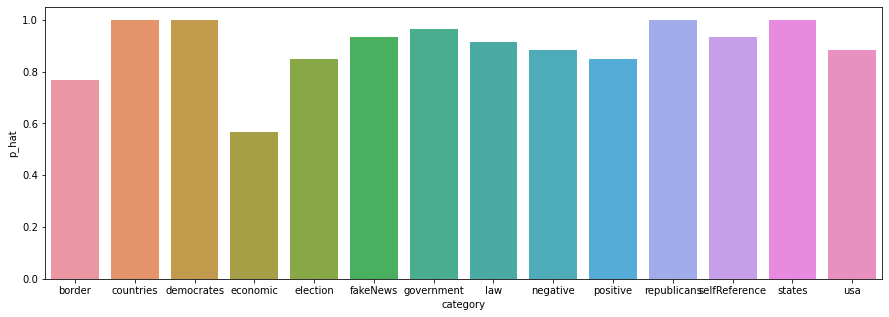

In [147]:
# Over all coherence
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
totalCoherence = coherenceTable.groupby('category').mean().reset_index()
#totalCoherence
sns.barplot(data = totalCoherence, x = 'category', y = 'p_hat')
totalCoherence

<AxesSubplot:xlabel='category', ylabel='p_hat'>

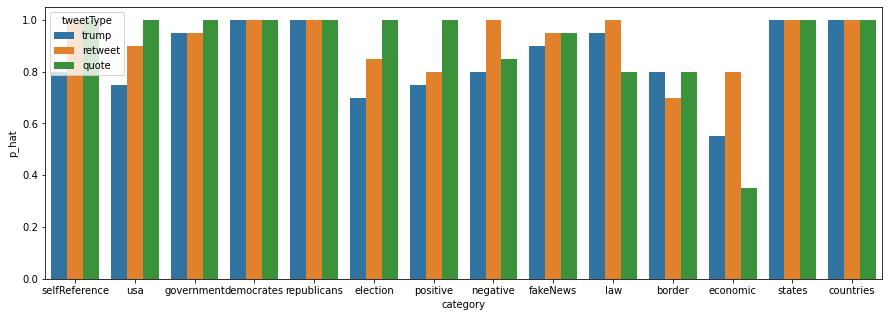

In [149]:
# Coherence by category
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = coherenceTable, x = 'category', y = 'p_hat', hue = 'tweetType')

In [150]:
# Export

tweets.to_csv('C:\\Users\\John\\Desktop\\SpeakAi\\trumpClean.csv')